In [2]:
from random import randint
import datetime
import numpy as np

In [3]:
# UnixTime
t2010 = 1262282400

In [8]:
dataset_in = []
dataset_out = []
for _ in range(100):
    v_p = randint(400,10000)
    v_s = randint(400, v_p)
    x0 = randint(-18000,18000)
    y0 = randint(-9000,9000)
    z0 = randint(-5000,0)
    t0 = randint(1, 648023579)
    t0 = t0 - (t0//1000)*1000
    dataset_out.append([x0,y0,z0,t0])
    ins = [v_p, v_s]
    for i in range(3):
        x = x0 + randint(-100,100)
        y = y0 + randint(-100,100)
        z = z0 + randint(-200,2000)
        t_p = t0 + (1 / v_p) * (((x - x0)**2 + (y - y0)**2 + (z - z0)**2)**0.5) - (t0//1000)*1000
        t_s = t0 + (1 / v_s) * (((x - x0)**2 + (y - y0)**2 + (z - z0)**2)**0.5) - (t0//1000)*1000
        ins.append(x)
        ins.append(y)
        ins.append(z)
        ins.append(t_p)
        ins.append(t_s)

    dataset_in.append(ins)
print(dataset_in[0], dataset_out[0])
np.save('in.npy',np.array(dataset_in))
np.save('out.npy',np.array(dataset_out))

[3296, 1711, -15650, 462, -2729, 911.2036901678188, 911.3923803583463, -15741, 496, -3221, 911.0533816791407, 911.1028322702791, -15779, 634, -1918, 911.4480611039654, 911.8631264749679] [-15730, 540, -3391, 911]


In [10]:
dataset_in = dataset_in[0]

In [5]:
def find_hypocenter(station_xyz:list, t:list, t_delta_p_s:list, v_p, v_s):
    r_s = [((v_p * v_s * delta_p_s)/(v_p - v_s)) for delta_p_s in t_delta_p_s] # метод сфер
    l = []  # Расстояния между станциями
    for i in range(3):
        if i == 2:
            l.append(((station_xyz[i][0]-station_xyz[0][0])**2 + (station_xyz[i][1]-station_xyz[0][1])**2 + (station_xyz[i][2]-station_xyz[0][2])**2)**0.5)
        else:
            l.append(((station_xyz[i][0]-station_xyz[i+1][0])**2 + (station_xyz[i][1]-station_xyz[i+1][1])**2 + (station_xyz[i][2]-station_xyz[i+1][2])**2)**0.5)
    
    t_r = []  # разность времен прихода продольной сейсмической волны к i-ому и i + 1 сейсмодатчику
    for i in range(3):
        if i == 2:
            t_r.append(t[i] - t[0])
        else:
            t_r.append(t[i] - t[i+1])

    # m = []
    # for i in range(3):
    #     m.append(((v_p - v_s) * (l[i] - (t_r[i]**2) * v_p**2) - 2 * (t_r[i] * t_delta_p_s[i] * (v_p**2) * v_s))/(2 * (l[i] * v_p * v_s * t_delta_p_s[i])))
    
    # r_s = []  # метод сферы и гиперболоида
    # for i in range(3):
    #     r_s.append((l[i] - (t_r[i]**2)*(v_p**2))/(2 * (l[i] * v_p * v_s * t_delta_p_s[i])))

    g = []
    for i in range(3):
        if i == 2:
            g.append((l[i]**2 - r_s[0]**2 + r_s[i]**2)/(2 * l[i]))
        else:
            g.append((l[i]**2 - r_s[i+1]**2 + r_s[i]**2)/(2 * l[i]))

    r_o = []
    for i in range(3):
        r_o.append((r_s[i]**2 - g[i]**2)**0.5)

    x_o = []
    y_o = []
    for i in range(3):
        if i == 2:
            x_o.append(station_xyz[0][0] * (g[i] / l[i]) + station_xyz[i][0] * (1 - (g[i] / l[i])))
            y_o.append(station_xyz[0][1] * (g[i] / l[i]) + station_xyz[i][1] * (1 - (g[i] / l[i])))
        else:
            x_o.append(station_xyz[i+1][0] * (g[i] / l[i]) + station_xyz[i][0] * (1 - (g[i] / l[i])))
            y_o.append(station_xyz[i+1][1] * (g[i] / l[i]) + station_xyz[i][1] * (1 - (g[i] / l[i])))

    print(x_o)
    print(y_o)
    print(r_s)
    print(r_o)

    x = x_o[0] + ( r_o[1]**2 * y_o[2] - y_o[2] * x_o[1]**2  - y_o[2] * y_o[1]**2 + y_o[1] * x_o[2]**2 + y_o[2]**2 * y_o[1]
                  + r_o[0]**2 * y_o[1] - r_o[2]**2 * y_o[1] - r_o[0]**2 * y_o[2])/(
        2 * (y_o[1] * x_o[2] - x_o[1] * y_o[2]))
    
    y = y_o[0] + ( r_o[1]**2 * x_o[2] - x_o[2] * y_o[1]**2  - x_o[2] * x_o[1]**2 + x_o[1] * y_o[2]**2 + x_o[2]**2 * x_o[1]
                  + r_o[0]**2 * x_o[1] - r_o[2]**2 * x_o[1] - r_o[0]**2 * x_o[2])/(
        2 * (x_o[1] * y_o[2] - y_o[1] * x_o[2]))

    z = (r_s[0]**2 - x**2 - y**2)**0.5
    return [x, y, z]
    # m = []
    # for i in range(3):
    #     m.append(((v_p - v_s) * (l[i] - (t_r[i]**2) * v_p**2) - 2 * (t_r[i] * t_delta_p_s[i] * (v_p**2) * v_s))/(2 * (l[i] * v_p * v_s * t_delta_p_s[i])))
    
    # r_g = []  # метод сферы и гиперболоида
    # for i in range(3):
    #     r_g.append((l[i] - (t_r[i]**2)*(v_p**2))/(2 * (l[i] * v_p * v_s * t_delta_p_s[i])))
    

In [6]:
dataset_in = [5000, 3000, 200, 0, -421, 0.0446, 0.074, 200, 100, -100, 0.04, 0.0666, 200, 200, -117, 0.0446, 0.074]

In [11]:
print(find_hypocenter([[dataset_in[2], dataset_in[3], dataset_in[4]], [dataset_in[7], dataset_in[8], dataset_in[9]], [dataset_in[12], dataset_in[13], dataset_in[14]]],
                      [dataset_in[5], dataset_in[10], dataset_in[15]],
                      [dataset_in[6] - dataset_in[5], dataset_in[11] - dataset_in[10], dataset_in[16] - dataset_in[15]],
                      dataset_in[0],
                      dataset_in[1]
                      ))

# [2999.9999999999955, 3000.000000000119, 2000.0]
# [3166.0000000000095, 1000.0, 3166.0000000000673]
# [-6.936985466943049e-05, -0.00033265462565242596, -0.0007667465074641657]
# [(3247.0195882902876+1.13776663897302e-13j), (5066.319235129315-5.248210342204875e-14j), (3.684677453796645e-13-6017.534943727548j)]

[-15771.442364046208, -15736.22636191531, -15555.96461376292]
[507.3740700831984, 478.66415642928666, 336.619485017231]
[671.3627931302378, 175.9460144475022, 1476.8093986700976]
[53.020698941027746, 61.97358893936141, 276.88787776283505]
[-23313.785114056034, 11455.43043642218, (1.5900480508405766e-12+25967.455301359216j)]


In [12]:
import matplotlib.pyplot as plt

In [ ]:
circle1 = plt.Circle((427.9708188615692, 39.58303125901048), 366.3018249776558, color='g', fill=False)
circle2 = plt.Circle((174, 100), 298, color='g', fill=False)
circle3 = plt.Circle((200, -49), 237, color='g', fill=False)

fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.plot([200,400,200,711], [532,100,100,-28], 'bo')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle3)

In [23]:
def find_hypocenter_math(x1, x2, x3, y1, y2, y3, z1, z2, z3, t:list, t_delta_p_s:list, v_p, v_s):
    r_s = [((v_p * v_s * delta_p_s)/(v_p - v_s)) for delta_p_s in t_delta_p_s] # метод сфер


    r_s = [20000**0.5, 100, 20000**0.5]
    print(r_s)
    x = (x2**2 + r_s[0]**2 - r_s[1]**2)/(2 * x2)
    y = (x3**2 + y3**2 + r_s[0]**2 - r_s[2]**2 - (2 * x3 * x))/(2 * y3)
    z = (r_s[0]**2 - x**2 - y**2)**0.5
    return [x, y, z]

In [25]:
print(find_hypocenter_math(1,1,1, -100, 0, 100, 1, 1, 1,
                      [0.0446, 0.04, 0.0446],
                      [0.0294, 0.0266666666, 0.0294],
                      5000,
                      3000
                      ))


[141.4213562373095, 100, 141.4213562373095]
[5000.5, 0.0, (3.06069839026759e-13+4998.499799939978j)]


In [13]:
import numpy                                             
from numpy import sqrt, dot, cross                       
from numpy.linalg import norm                            

# Find the intersection of three spheres                 
# P1,P2,P3 are the centers, r1,r2,r3 are the radii       
# Implementaton based on Wikipedia Trilateration article.                              
def trilaterate(P1,P2,P3,r1,r2,r3):                      
    temp1 = P2-P1                                        
    e_x = temp1/norm(temp1)                              
    temp2 = P3-P1                                        
    i = dot(e_x,temp2)                                   
    temp3 = temp2 - i*e_x                                
    e_y = temp3/norm(temp3)                              
    e_z = cross(e_x,e_y)                                 
    d = norm(P2-P1)                                      
    j = dot(e_y,temp2)                                   
    x = (r1*r1 - r2*r2 + d*d) / (2*d)                    
    y = (r1*r1 - r3*r3 -2*i*x + i*i + j*j) / (2*j)       
    temp4 = r1*r1 - x*x - y*y                            
    if temp4<0:                                          
        raise Exception("The three spheres do not intersect!");
    z = sqrt(temp4)                                      
    p_12_a = P1 + x*e_x + y*e_y + z*e_z                  
    p_12_b = P1 + x*e_x + y*e_y - z*e_z                  
    return p_12_a,p_12_b

In [14]:
t_delta_p_s = [0.0294, 0.0266666666, 0.0294]
v_p = 5000
v_s = 3000
r_s = [((v_p * v_s * delta_p_s)/(v_p - v_s)) for delta_p_s in t_delta_p_s] # метод сфер

In [17]:

r_s = [142, 100, 142]
print(r_s)

trilaterate(P1, P2, P3, 20000**0.5, 100, 20000**0.5)

[142, 100, 142]


C:\Users\ETP\AppData\Local\Temp\ipykernel_14600\3812375326.py:14: RuntimeWarning: invalid value encountered in divide
  e_y = temp3/norm(temp3)


(array([nan, nan, nan]), array([nan, nan, nan]))

In [18]:
import numpy as np


def get_spanning_vectors_of_3d_plane(n):
    """
    Gets two orthogonal spanning vectors of a plane with normal n.
    :param n: (array_like) normal of plane of dimension 3, does not have to be normalized, but is normalized internally.
    :return: u,v (ndarray) of dimension 3 which are the spanning vectors.

    Note this function uses random vectors to initialize guesses which may be undesirable,
    this can easily be changed to use deterministic guesses but requires more checks.
    """

    n = np.asarray(n)
    n = n / np.linalg.norm(n)

    # Generate u
    while True:
        u = np.random.randn(3)
        # Must be careful not to generate a co-linear vector
        if np.abs(np.dot(u, n)) < 1e-6:
            continue  # retry
        u = u - np.dot(u, n) * n
        u = u / np.linalg.norm(u)
        break

    # Generate v
    while True:
        v = np.random.randn(3)
        # Must be careful not to generate a co-linear vector
        if np.abs(np.dot(v, n)) < 1e-6 or np.abs(np.dot(v, u)) < 1e-6:
            continue  # retry
        v = v - np.dot(v, u) * u
        v = v - np.dot(v, n) * n
        v = v / np.linalg.norm(v)
        break

    return u, v


def eval_circle(t, circle):
    """
    Evaluates a circle in 3d.
    :param t: (ndarray) a ndarray of one or more points in 3d in to evaluate circle at.
    :param circle: (circle) the circle in 3d to evaluate.
    :return: (ndarray) a ndarray of the 3d points that each value of t maps to, on on each row.

    Note for a description of the circle structure, please see documentation of Sphere.get_circle_of_intersection.
    """
    h, c, u, v = circle
    return c + h * np.cos(t.reshape(-1, 1)) * u + h * np.sin(t.reshape(-1, 1)) * v


def solve_sin_cos_eq(alpha, beta, gamma):
    """
    Solves the equation
    \alpha cos(t) + \beta sin(t) = \gamma
    for t.

    :param alpha: (real)
    :param beta: (real)
    :param gamma: (real)
    :return: all solutions for t to the equation.

    """
    sq = np.square

    # Solve for tt = tan(t/2) in the original equations using
    # Weierstrass Substitution:
    # cos(t) = (1-tt^2)/(1+tt^2)
    # sin(t) = (2tt)/(1+tt^2)

    c = gamma - alpha
    b = -2 * beta
    a = gamma + alpha
    discriminant = sq(b) - 4 * a * c
    if discriminant < 0:
        return np.nan, np.nan
    tt_0 = (-b + np.sqrt(discriminant)) / (2 * a)
    tt_1 = (-b - np.sqrt(discriminant)) / (2 * a)

    t_0 = 2 * np.arctan(tt_0)
    t_1 = 2 * np.arctan(tt_1)

    t_0 = t_0 if t_0 > 0 else t_0 + 2 * np.pi
    t_1 = t_1 if t_1 > 0 else t_1 + 2 * np.pi

    return t_0, t_1


class Sphere:

    def __init__(self, center_sigma=1., radius_sigma=2.):
        """
        Generates a random sphere in 3d.
        :param center_sigma: std. deviation in random center.
        :param radius_sigma: std. deviation in random radius.
        """
        self.center = center_sigma * np.random.randn(3)
        self.radius = radius_sigma * np.abs(np.random.randn())

    def check_intersection(self, other_sphere):
        """
        Checks to see if this sphere intersects with given `other_sphere`.
        :param other_sphere:
        :return:
        """
        r0 = other_sphere.radius
        c0 = other_sphere.center
        r1 = self.radius
        c1 = self.center
        if r1 > r0:
            r0, r1 = r1, r0
            c0, c1 = c1, c0
        d = np.linalg.norm(c1 - c0)
        if d < r0:
            return r1 >= r0 - d
        else:
            return d < r0 + r1

    def get_circle_of_intersection(self, other_sphere):
        """
        Gets the circle in 3d of the intersection of this sphere with `other_sphere`.
        Note, an intersection should exist for this function to be sensible.
        :param other_sphere:
        :return: (circle) the circle of intersection.

        Note: a `circle` is defined by a tuple
        circle = h, c, u, v
        which describes the analytic form
        x(t) = c + h*cos(t)*u + h*sin(t)*v
        where h is a constant (radius) and c, u, v are all 3d vectors, and x(t) is the 3d
        circle as a function of time.
        """
        r0 = other_sphere.radius
        c0 = other_sphere.center
        r1 = self.radius
        c1 = self.center
        if r1 > r0:
            r0, r1 = r1, r0
            c0, c1 = c1, c0
        n = c1 - c0
        d = np.linalg.norm(n)
        u, v = get_spanning_vectors_of_3d_plane(n / d)
        x = (r1 * r1 - r0 * r0 + d * d) / (2 * d)
        if d < r0:
            x = -x
            c = c0 + n / d * (d + x)
        else:
            c = c0 + n / d * (d - x)
        h = np.sqrt(r1 * r1 - x * x)
        return h, c, u, v

    def check_point_is_on_sphere(self, x):
        """
        Checks to see if a point is on a sphere (in 3d.)
        :param x:  (array_like) a 3d real point.
        :return: true if detected on sphere (within precision) false otherwise.
        """
        dx = x - self.center
        return np.abs(np.sum(np.square(dx)) - np.square(self.radius)) < 1e-6

    def find_intersection_with_circle(self, circle):
        """
        Finds the two points that define the intersection to this sphere with `circle`, if such an intersection exists.
        :param circle: (circle) the circle to intersect with.
        :return: (tuple) two 3d points that define the intersection. If no intersection exists returns None.
        """
        h, c, u, v = circle
        cd = c - self.center
        gamma = np.square(self.radius) - np.dot(cd, cd) - np.square(h)
        alpha = 2 * np.dot(cd, u) * h
        beta = 2 * np.dot(cd, v) * h

        t0, t1 = solve_sin_cos_eq(alpha, beta, gamma)

        if np.isnan(t0) or np.isnan(t1):
            return None

        return eval_circle(t0, circle)[0], eval_circle(t1, circle)[0]


np.random.seed(1012)

spheres = [Sphere(P1, r_s[0]),Sphere(P1, r_s[1]),Sphere(P1, r_s[2])]


if not spheres[0].check_intersection(spheres[1]):
    raise RuntimeError(
        "In the generated example the first two spheres do not intersect; no 3-sphere intersection is possible.")

circle = spheres[0].get_circle_of_intersection(spheres[1])

ret_value = spheres[2].find_intersection_with_circle(circle)
if ret_value:
    p0, p1 = ret_value
    print ('The two 3d points that are in the intersection of the 3 spheres are:')
    print ('P0 = ', p0)
    print ('P1 = ', p1)
    print ('The following checks to see P0 exists on all three spheres:', all(
        [s.check_point_is_on_sphere(p0) for s in spheres]))
    print ('The following checks to see P1 exists on all three spheres:', all(
        [s.check_point_is_on_sphere(p1) for s in spheres]))
else:
    print ('No intersection exists of the circle with the 3rd sphere.')

No intersection exists of the circle with the 3rd sphere.


In [19]:
def intersect3spheres(x1, x2, x3, y1, y2, y3, z1, z2, z3, r1, r2, r3):
	# var a1, b1, c1, k1, a3, b3, c3, k3, a31, b31, 
	# 	e, f, g, h, A, B, C, x, y, z, x_, y_, z_, rootD;

	k1 = r1 * r1 - r2 * r2 - x1 * x1 + x2 * x2 - y1 * y1 + y2 * y2 - z1 * z1 + z2 * z2
	
	a1 = 2 * (x2 - x1)
	b1 = 2 * (y2 - y1)
	c1 = 2 * (z2 - z1)
	
	k3 = r3 * r3 - r2 * r2 - x3 * x3 + x2 * x2 - y3 * y3 + y2 * y2 - z3 * z3 + z2 * z2
	
	a3 = 2 * (x2 - x3)
	b3 = 2 * (y2 - y3)
	c3 = 2 * (z2 - z3)

	if (a1 == 0) :
		e = -c1 / b1
		f = k1 / b1
	elif (a3 == 0):
		e = -c3 / b3
		f = k3 / b3;		
	else:	
		a31 = a3 / a1
		e = - ((a31 * c1 - c3) / (a31 * b1 - b3))
		f = (a31 * k1 - k3) / (a31 * b1 - b3)
	
	if (b1 == 0):
		g = -c1 / a1
		h = k1 / a1
	elif (b3 == 0):
		g = -c3 / a3
		h = k3 / a3
		
	else:
	
		b31 = b3 / b1
		g = - ((b31 * c1 - c3) / (b31 * a1 - a3))
		h = (b31 * k1 - k3) / (b31 * a1 - a3)
	

	A = g * g + e * e + 1
	B = -x1 * g - y1 * e - 2 * z1 - x1 * g - y1 * e + 2 * g * h + 2 * e * f
	C = x1 * x1 + y1 * y1 + z1 * z1 - 2 * x1 * h - 2 * y1 * f + h * h + f * f - r1 * r1
	
	rootD = (B * B - 4 * A * C)**0.5
	
	z = (-B + rootD) / (2 * A)
	z_ = (-B - rootD) / (2 * A)


	x = g * z + h
	x_ = g * z_ + h
	
	y = e * z + f
	y_ = e * z_ + f
	
	return [x, y, z, x_, y_, z_]

In [21]:
s = intersect3spheres(1,-100,0, 1,0,500, 1,100,0, 142, 100, 142)
print(s)

[(-76.92035706828146+162.41894338951485j), (250.4969216313025+0.6575665724271839j), (76.38425108823105+165.70677625165078j), (-76.92035706828149-162.41894338951485j), (250.4969216313025-0.6575665724271839j), (76.38425108823103-165.70677625165078j)]


In [ ]:
r_s = [((v_p * v_s * delta_p_s)/(v_p - v_s)) for delta_p_s in t_delta_p_s] # метод сфер

WORKING!
  |||
  \ /

In [26]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import hypo
from ttcrpy.rgrid import Grid3d

In [31]:
P1 = np.array([0,-0.100,0])
P2 = np.array([0.175,0,0])
P3 = np.array([0,0.100,0])

rcv = np.array([P1,P2,P3])
ircv = np.arange(rcv.shape[0]).reshape(-1,1)   # vector of rcv indices
nsta = rcv.shape[0]

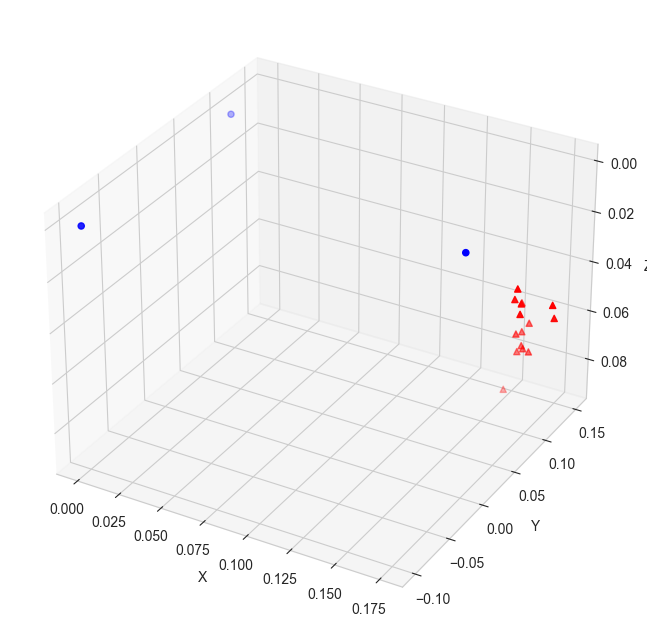

In [32]:
nev = 15
src = np.vstack((np.arange(nev),                                            # event ID
                 np.linspace(0., 50., nev) + np.random.randn(nev),          # origin time
                 0.160 + 0.005*np.random.randn(nev),                           # x
                 0.140 + 0.005*np.random.randn(nev),                           # y
                 0.060 + 0.010*np.random.randn(nev))).T                        # z

h_true = src.copy()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rcv[:,0], rcv[:,1], rcv[:,2], c='b', marker='o')
ax.scatter(src[:,2], src[:,3], src[:,4], c='r', marker='^')
ax.invert_zaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()